In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog, curve_fit
import gurobipy as gp
from gurobipy import GRB

In [15]:
# Algorithm 1 Simple Online Algorithm 
# 1: Input: d = b/n 
# 2: Initialize p1 = 0 
# 3: for t = 1, ..., n do 
# 4:        Set xt = {1, rt > at>pt ; 0, rt ≤ at>pt }
# 5:        Update dual price with sub gradient method: Compute p[t+1] = p[t]+ γt (a[t] * x[t] − d) ; p[t+1] = p[t+1] ∨ 0 
# 6: end for 
# 7: Output: x = (x1, ..., xn)
def SO(A, b, c, gemma = 0.01):
    """
    SO: Simple Online Algorithm for online resource allocation.
    """
    # Solve the offline LP to find the optimal offline solution
    # Check the input parameters # Solve the offline LP to find the optimal offline solution
    n_const, n_time = A.shape
    result = linprog(-c, A_ub=A, b_ub=b, bounds=(0, 1), method='highs', options={"disp": False})
    # Optimal solution to the offline LP
    offline_x = result.x

    # 1: Input: A, b, c, gemma
    n_const, n_time = A.shape
    d = b / n_time
    
    # 2: Initialize p1 = 0 
    p_hat = np.zeros(n_const)
    online_x = np.zeros(n_time)
    
    # 3: for t = 1, ..., n do 
    for t in range(n_time):
        # 4: Set xt = {1, rt > at>pt ; 0, rt ≤ at>pt }
        # If constraints permit, set
        x_tide = 1 if c[t] > np.dot(p_hat, A[:, t]) else 0
            
        # Check Stopping Time and update decision
        if np.any(A[:, :t] @ online_x[:t] + A[:, t] * x_tide > b):
            online_x[t] = 0
        else:
            online_x[t] = x_tide
        
        # 5: Update dual price with sub gradient method: Compute p[t+1] = p[t]+ γt (a[t] * x[t] − d) ; p[t+1] = p[t+1] ∨ 0 
        p_hat = p_hat + gemma * (A[:, t] * online_x[t] - d)
        p_hat = np.maximum(p_hat, 0)

        # Compute the competitive ratio : online objective value / offline objective value
    cr = np.dot(c, online_x) / np.dot(c, offline_x)
    return cr, online_x, offline_x

In [16]:
# Algorithm 2 Dynamic Learning Algorithm
# 1: Input: A, b, c, delta
# 2: Initialize: Find δ ∈(1, 2] and L > 0 s.t. δ^L=n
# 3:Let tk =δ^k, k = 1, 2, ..., L − 1 and tL = n + 1
# 4: Initialize decision variable, and Set x1 = ... = xt1 = 0
# 5: for k = 1, 2, :::, L − 1 do
# 6:     Update dual value p_hat
# 7:     for t = tk + 1, ..., tk+1 do
# 8:         if the constraints are not violated
# 9:             Set xt = 1
# 10:         else
# 11:             Set xt = 0
# 12:     end for
# 13: end for
# 14: Output: x = (x1, ..., xn)
def DL(A, b, c, delta = 2):
    """
    DL: Dynamic Learning algorithm for online resource allocation.

    Args:
        A (ndarray): A matrix of constraints with shape (n_const, n_time).
        b (ndarray): A vector of available resources with shape (n_const,).
        c (ndarray): A vector of resource values with shape (n_time,).
        delta (float): Learning rate parameter (1 < delta <= 2).

    Returns:
        float: Competitive ratio (cr) of the allocation.
    """
    # Check the input parameters
    if not (1 < delta <= 2):
        raise ValueError("delta must be between 1 and 2")
    if A.shape[0] != len(b) or A.shape[1] != len(c):
        raise ValueError("Dimension mismatch in input matrices")

    # Solve the offline LP to find the optimal offline solution
    n_const, n_time = A.shape
    result = linprog(-c, A_ub=A, b_ub=b, bounds=(0, 1), method='highs', options={"disp": False})
    # Optimal solution to the offline LP
    offline_x = result.x

    # 2: Initialize: Find δ ∈(1, 2] and L > 0 s.t. δ^L=n
    if delta > 1:
        L = int(np.ceil(np.log(n_time) / np.log(delta)))
    else:
        L = n_time

    # 3:Let tk =δ^k, k = 1, 2, ..., L − 1 and tL = n + 1
    # Define time steps for updating the model (learning intervals)
    time_steps = np.floor(delta ** np.arange(1, L - 1)).astype(int)
    time_steps = np.concatenate([time_steps, [n_time]]) # here isn't n_time + 1

    # 4: Initialize decision variable, and Set x1 = ... = xt1 = 0
    online_x = np.zeros(n_time)
    online_x[0:time_steps[0]] = 0

    # 5: for k = 1, 2, :::, L − 1 do
    for k in range(1, L - 1):
        t_k = time_steps[k - 1]
        
        # Update dual value p_hat
        # min b^T p / n + y / t_k
        # s.t. A^T p + y >= c
        #       p >= 0, y >= 0
        cc = np.concatenate([b / n_time, np.ones(t_k) / t_k])
        AA = np.hstack([
            A[:, :t_k].T,  # Shape: (t_k, n_const)
            np.eye(t_k)     # Shape: (t_k, t_k)
        ])
        bb = c[:t_k]
        dual_value = linprog(
                c=cc,
                A_ub=- AA,
                b_ub=- bb,
                bounds=(0, None),
                method='highs',
                options={"disp": False}
            ).x
        p_hat = dual_value[:n_const]

        # Decide whether to allocate resources at time t
        for t in range(t_k + 1, time_steps[k]):
            
            # If constraints permit, set
            x_tide = 1 if c[t] > np.dot(p_hat, A[:, t]) else 0
            
            # Check Stopping Time and update decision
            if np.any(A[:, :t] @ online_x[:t] + A[:, t] * x_tide > b):
                online_x[t] = 0
            else:
                online_x[t] = x_tide

            if t == n_time - 1:
                break

    # Compute the competitive ratio : online objective value / offline objective value
    cr = np.dot(c, online_x) / np.dot(c, offline_x)

    return cr, online_x, offline_x

In [17]:
# Algorithm 3 Action-History-Dependent Learning Algorithm
# 1: Input: A, b, c, delta
# 2: Initialize the constraint/remaining resources
# 3: Initialize the dual price
# 4: for t = 1, ..., n do
# 5:     if t < n, solve its dual problem and obtain the dual price
# 6:     Observe (rt, at) and set xt
# 7:     Update the constraint vector
# 8: end for
# 9: Output: x = (x1, ..., xn)
def AHDL(A, b, c, delta = 2):
    """
    AHDL: Action-History-Dependent Learning Algorithm

    Args:
        A (ndarray): A matrix of constraints with shape (n_const, n_time).
        b (ndarray): A vector of available resources with shape (n_const,).
        c (ndarray): A vector of resource values with shape (n_time,).
        delta (float): Learning rate parameter (1 < delta <= 2).

    Returns:
        float: Competitive ratio (cr) of the allocation.
    """
    # Initialize the constraint/remaining resources
    b_rem = b.copy()
    
    # Solve the offline LP to find the optimal offline solution
    n_const, n_time = A.shape
    result = linprog(-c, A_ub=A, b_ub=b, bounds=(0, 1), method='highs', options={"disp": False})
    # Optimal solution to the offline LP
    offline_x = result.x

    # Initialize decision variables
    online_x = np.zeros(n_time)
    online_x[0] = 1 if c[0] > 0 else 0  # Decide the first time step based on c[0]
    
    # Check feasibility for the first decision
    if np.any(A[:, 0] * online_x[0] > b):
        online_x[0] = 0  # Set to 0 if not feasible

    # Update remaining resources
    b_rem -= A[:, 0] * online_x[0]

    # 3: Initialize the dual price
    p_hat = np.zeros(n_const)

    # 4: for t = 1, ..., n do
    # Iterate through the remaining time steps
    for t in range(1, n_time):       
        # If t < n, solve its dual problem and obtain the dual price
        if t < n_time - 1:
            # min b^T p / (n-t) + y/t
            # s.t. A^T p + y >= c
            #       p >= 0, y >= 0
            cc = np.concatenate([b_rem / (n_time - t), np.ones(t) / t])
            AA = np.hstack([
                A[:, :t].T,  # Shape: (t, n_const)
                np.eye(t)     # Shape: (t, t)
            ])
            bb = c[:t]
            result = linprog(
                c=cc,
                A_ub=- AA,
                b_ub=- bb,
                bounds=(0, None),
                method='highs',
                options={"disp": False}
            )
            dual_value = result.x

            if result.success:
                p_hat = dual_value[:n_const]
            else:
                # 如果求解失败，使用上一次的 p_hat
                print(f"Warning: LP solving failed at time {t}. Status: {result.status}")

        # 5: Observe (rt, at) and set xt
        # if the constraints are not violated
        x_tide = 1 if c[t] > np.dot(p_hat, A[:, t]) else 0
            
        # Check feasibility and update decision
        if np.any(A[:, :t] @ online_x[:t] + A[:, t] * x_tide > b):
            online_x[t] = 0
        else:
            online_x[t] = x_tide

        # Update the constraint vector
        # b[i,t] = b[i,t-1] - a[i,t]*x(t)
        b_rem = b_rem - A[:, t] * online_x[t]

        if np.any(b_rem[:] < 0):
            break

    # Compute the competitive ratio : online objective value / offline objective value
    cr = np.dot(c, online_x) / np.dot(c, offline_x)

    return cr, online_x, offline_x


In [18]:
# Create random test data
np.random.seed(42)  # For reproducibility

# Create test data
n_const = 4  # Number of constraints
n_time = 1000  # Number of time steps   

# Create constraint matrix A
A = np.random.rand(n_const, n_time)

# Create resource vector b
b = np.ones(n_const) * np.sqrt(n_time)

# Create value vector c
c = np.random.rand(n_time)

# Test the DL algorithm
delta = 2  # Learning rate parameter between 1 and 2

print(f"Test case dimensions: {A.shape}")
print(f"Resource constraints (b): {b}")
print(f"Value vector (c): {c.shape}")

cr, online_x, offline_x = SO(A, b, c, delta)
# print("Offline solution: ", offline_x)
# print("Online solution: ", online_x)
print(f"Competitive ratio of Simple Online (SO): {cr:.4f}")

cr, online_x, offline_x = DL(A, b, c, delta)
# print("Offline solution: ", offline_x)
# print("Online solution: ", online_x)
print(f"Competitive ratio of Dynamic Learning (DL): {cr:.4f}")

cr, online_x, offline_x = AHDL(A, b, c, delta)
# print("Offline solution: ", offline_x)
# print("Online solution: ", online_x)
print(f"Competitive ratio of Action-History-Dependent Learning (AHDL): {cr:.4f}")

Test case dimensions: (4, 1000)
Resource constraints (b): [31.6227766 31.6227766 31.6227766 31.6227766]
Value vector (c): (1000,)
Competitive ratio of Simple Online (SO): 0.6969
Competitive ratio of Dynamic Learning (DL): 0.8342
Competitive ratio of Action-History-Dependent Learning (AHDL): 0.9187


Experiment 1/10, Constraints 2: SO=0.9055, DL=0.8846, AHDL=0.9417
Experiment 1/10, Constraints 4: SO=0.7945, DL=0.8334, AHDL=0.9102
Experiment 1/10, Constraints 6: SO=0.6913, DL=0.8099, AHDL=0.8728
Experiment 1/10, Constraints 8: SO=0.5670, DL=0.7953, AHDL=0.8592
Experiment 1/10, Constraints 10: SO=0.5881, DL=0.7976, AHDL=0.8537
Experiment 1/10, Constraints 12: SO=0.5271, DL=0.8041, AHDL=0.8801
Experiment 1/10, Constraints 14: SO=0.5509, DL=0.7861, AHDL=0.8739
Experiment 1/10, Constraints 16: SO=0.5276, DL=0.7629, AHDL=0.8716
Experiment 1/10, Constraints 18: SO=0.4892, DL=0.8355, AHDL=0.8554
Experiment 1/10, Constraints 20: SO=0.5837, DL=0.7869, AHDL=0.8571
Experiment 2/10, Constraints 2: SO=0.8804, DL=0.7826, AHDL=0.9560
Experiment 2/10, Constraints 4: SO=0.7474, DL=0.7658, AHDL=0.9316
Experiment 2/10, Constraints 6: SO=0.6532, DL=0.7956, AHDL=0.8965
Experiment 2/10, Constraints 8: SO=0.5899, DL=0.8646, AHDL=0.9037
Experiment 2/10, Constraints 10: SO=0.6413, DL=0.8020, AHDL=0.8748
Exp

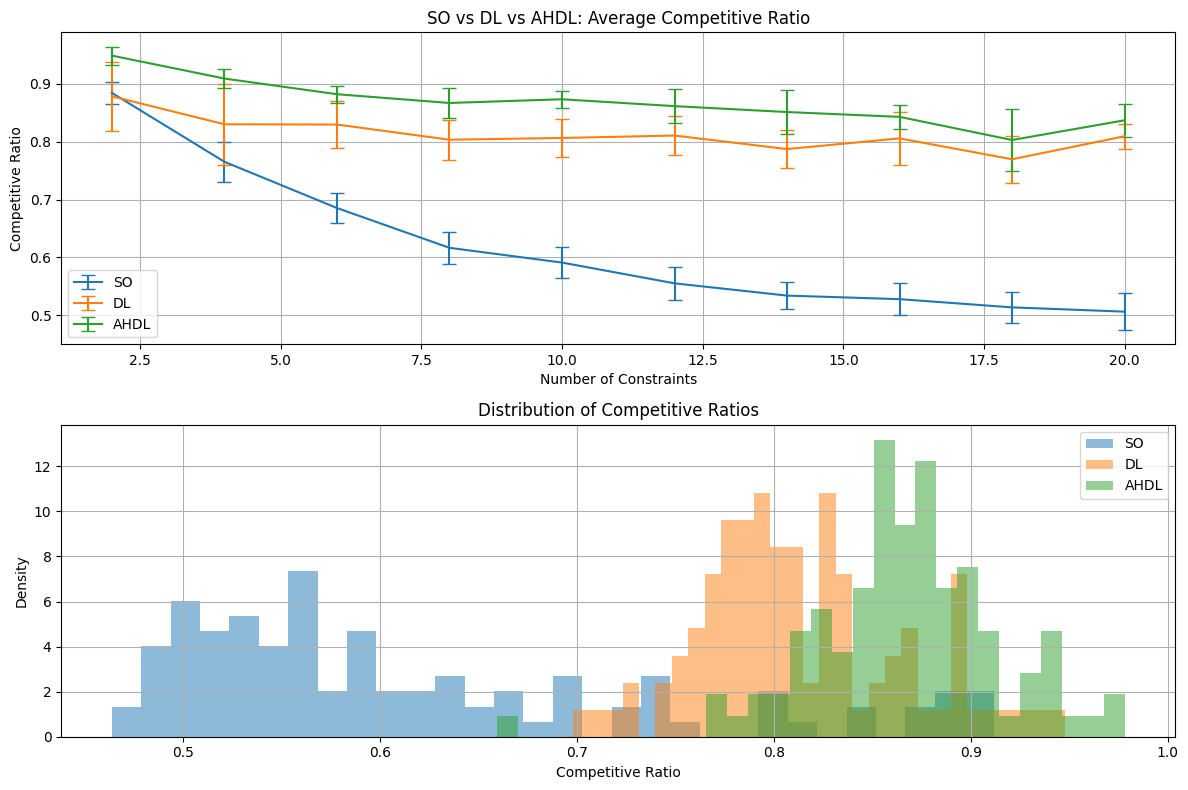


Statistical Summary:
SO - Mean: 0.6181, Std: 0.1216
DL - Mean: 0.8130, Std: 0.0513
AHDL - Mean: 0.8675, Std: 0.0474


In [19]:
def asymptotic_log(x, a, b):
    """Best asymptotic fit: f(x) = b + a * sqrt(log(x))"""
    return b + a * np.sqrt(np.log(x))

def asymptotic_power(x, a, b, p):
    """Power asymptotic fit: f(x) = b + a * x^p"""
    return b + a * x**p

def analyze_SO_DL_AHDL_comparison(n_times = 1000,  n_experiments=50):
    """
    Analyze the competitive ratios of SO, DL, and AHDL.

    Args:
        n_times (int): Number of time steps.
        n_experiments (int): Number of experiment instances.
    """

    # 测试参数
    n_const_range = np.arange(2, 21, 2)  # 约束数量范围
    delta = 1.5    # 学习率参数
    
    # 存储结果
    results_SO = np.zeros((n_experiments, len(n_const_range)))
    results_DL = np.zeros((n_experiments, len(n_const_range)))
    results_AHDL = np.zeros((n_experiments, len(n_const_range)))
    
    # 进行实验
    for exp in range(n_experiments):
        for i, n_const in enumerate(n_const_range):
            # 生成随机测试数据
            A = np.random.rand(n_const, n_time)
            b = np.ones(n_const) * np.sqrt(n_time)
            c = np.random.rand(n_time)
            
            # 运行3种算法
            cr_SO, _, _ = SO(A, b, c, delta)
            cr_DL, _, _ = DL(A, b, c, delta)
            cr_AHDL, _, _ = AHDL(A, b, c, delta)
            
            results_SO[exp, i] = cr_SO
            results_DL[exp, i] = cr_DL
            results_AHDL[exp, i] = cr_AHDL
            
            print(f"Experiment {exp+1}/{n_experiments}, Constraints {n_const}: SO={cr_SO:.4f}, DL={cr_DL:.4f}, AHDL={cr_AHDL:.4f}")
    
    # 绘制结果
    plt.figure(figsize=(12, 8))
    
    # 平均竞争比
    plt.subplot(2, 1, 1)
    plt.errorbar(n_const_range, np.mean(results_SO, axis=0), 
                yerr=np.std(results_SO, axis=0), label='SO', capsize=5)
    plt.errorbar(n_const_range, np.mean(results_DL, axis=0), 
                yerr=np.std(results_DL, axis=0), label='DL', capsize=5)
    plt.errorbar(n_const_range, np.mean(results_AHDL, axis=0), 
                yerr=np.std(results_AHDL, axis=0), label='AHDL', capsize=5)
    plt.xlabel('Number of Constraints')
    plt.ylabel('Competitive Ratio')
    plt.title('SO vs DL vs AHDL: Average Competitive Ratio')
    plt.legend()
    plt.grid(True)
    
    # 分布对比
    plt.subplot(2, 1, 2)
    plt.hist(results_SO.flatten(), bins=30, alpha=0.5, label='SO', density=True)
    plt.hist(results_DL.flatten(), bins=30, alpha=0.5, label='DL', density=True)
    plt.hist(results_AHDL.flatten(), bins=30, alpha=0.5, label='AHDL', density=True)
    plt.xlabel('Competitive Ratio')
    plt.ylabel('Density')
    plt.title('Distribution of Competitive Ratios')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 输出统计信息
    print("\nStatistical Summary:")
    print(f"SO - Mean: {np.mean(results_SO):.4f}, Std: {np.std(results_SO):.4f}")
    print(f"DL - Mean: {np.mean(results_DL):.4f}, Std: {np.std(results_DL):.4f}")
    print(f"AHDL - Mean: {np.mean(results_AHDL):.4f}, Std: {np.std(results_AHDL):.4f}")
    
    return results_SO, results_DL, results_AHDL

# 运行分析
if __name__ == "__main__":
    results_SO, results_DL, results_AHDL = analyze_SO_DL_AHDL_comparison( n_experiments=100)